This notebook is to understand INN framework by applying it to different examples 

Importing modules

In [1]:
# Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mc
import colorsys
#PyTorch
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
#from torchviz import make_dot # for visualizing the architecture as a graph

# FrEIA imports
from FrEIA.framework import InputNode,OutputNode, Node, ReversibleGraphNet,ConditionNode
from FrEIA.modules import GLOWCouplingBlock,PermuteRandom,RNVPCouplingBlock

# cuda
from torch.cuda.amp import GradScaler, autocast

# inverse kinematics
%run FABRIK_method.ipynb


Color Intensity setting

In [2]:

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

Setting up

In [3]:
# Configuring the parameters
parameters={'l':2.0}
# num_examples=30


# num_samples=reps*num_examples
num_inputs=4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

number_points=30
reps=10000
TEST_TRAIN_SPLIT=0.8
BATCH_SIZE=1000
num_samples = reps*number_points
current_lr=1e-3
num_epochs=30
mix_precision = False

# These are not yet being utilized.
mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]

width_exponents=[0.05,0.2,0.9]

Defining MMD

In [4]:
def MMD_matrix_multiscale(x, y, widths_exponents,device):
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = torch.clamp(rx.t() + rx - 2.*xx, 0, np.inf)
    dyy = torch.clamp(ry.t() + ry - 2.*yy, 0, np.inf)
    dxy = torch.clamp(rx.t() + ry - 2.*xy, 0, np.inf)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for C,a in widths_exponents:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a
    return torch.mean(XX + YY - 2.*XY)


In [5]:
# Move parameters to the CPU
for key, value in parameters.items():
    if isinstance(value, torch.Tensor):
        parameters[key] = value.to(device)

Defining the local INN architecture

In [6]:
# Defining the affine coupling blocks with conditional input
class loc_INN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device=device
        self.num_blocks=6
        self.inn=self.inn_model()
        # self.cond_net=self.subnet_cond(COND_OUT)

        self.trainable_params=[p for p in self.inn.parameters() if p.requires_grad]
        # print(self.trainable_params)
        if not self.trainable_params:
            print("No trainable paramters found..--> Exiting")
            raise SystemExit
        for param in self.trainable_params:
            param.data = 0.05 * torch.randn_like(param)

    def inn_model(self):
        
        def subnet_fc(cin,cout):
            return nn.Sequential(nn.Linear(cin,12),nn.ReLU(),nn.Linear(12,cout))

        nodes=[InputNode(int(num_inputs),name='input')]
        
        for k in range(self.num_blocks):
            nodes.append(Node(nodes[-1],GLOWCouplingBlock,{'subnet_constructor': subnet_fc,'clamp':2.0},conditions=None,name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],PermuteRandom,{'seed':k},name=F'permute_{k}'))

        nodes.append(OutputNode(nodes[-1],name='output'))
        return ReversibleGraphNet(nodes , verbose=False).to(self.device)

    def forward(self, x):
        return self.inn(x)
    
    def reverse(self, y_rev):
        return self.inn(y_rev, rev=True)

device="cpu"
loc_inn=loc_INN(device=device)# Move the entire model to device

# loc_inn=loc_inn.to(torch.float32) # Convert the entire model into double

# print(loc_inn)

Setting up the local INN function to work for this case

In [7]:
loc_inn=loc_INN(device)
loc_inn=loc_inn.to(torch.float32)
loc_inn=loc_inn.to(device)

# Loss 
MSE_loss=torch.nn.MSELoss().to(device) 
l1_loss=torch.nn.L1Loss().to(device)

# Instantiating the optimizers and adding the parameters
optimizer = torch.optim.Adam(loc_inn.trainable_params, lr=current_lr)
scaler=GradScaler(enabled=mix_precision)
scheduler=ExponentialLR(optimizer,gamma=0.95)

Setting up position functions

In [8]:
num_link = 4

def positions(phi,l=parameters["l"]*np.ones((num_link,))):
    """
    Find the coordinates of the joints of a 4R manipulator given the angles and the length of the links
    Args:
        phi : array of angles 
        l : the length of the links considering all links are of the same length
    """
    x, y=np.zeros((num_link+1,1)), np.zeros((num_link+1,1))
     
    for i in range(1, num_link+1):
        x[i,:], y[i,:]=x[i-1,:]+l[i-1]*np.cos(phi[i-1]), y[i-1,:]+l[i-1]*np.sin(phi[i-1])
    
    return np.concatenate((x,y),axis=1)


def posn(phi,l=parameters["l"]*np.ones((num_link,))):
    """
    Find the coordinates of the joints of a 4R manipulator given the angles and the length of the links
    Args:
        phi : array of angles 
        l : the length of the links considering all links are of the same length
    """
    x, y=np.zeros((num_link+1,)), np.zeros((num_link+1,))
     
    for i in range(1, num_link+1):
        x[i], y[i]=x[i-1]+l[i-1]*np.cos(phi[i-1]), y[i-1]+l[i-1]*np.sin(phi[i-1])
    return x,y

def end_effector_posn(phi, l=parameters["l"]*np.ones((num_link,))):
    """
    Used to find the end effector position of a planar serial manipulator given the joint angles and link lengths.
    Args:
        phi : The array of joint angles taken to be solved, numpy array of shape (num_entries, num_link)
        l : Length of the links
    """
    x, y = np.zeros((phi.shape[0], 1)), np.zeros((phi.shape[0], 1))
    
    for i in range(phi.shape[1]):
        x += l[i]*np.cos(phi[:,i]).reshape((phi.shape[0],1))
        y += l[i]*np.sin(phi[:,i]).reshape((phi.shape[0],1))

    return np.concatenate((x,y),axis=1)

Generating data, in a circular trajectory

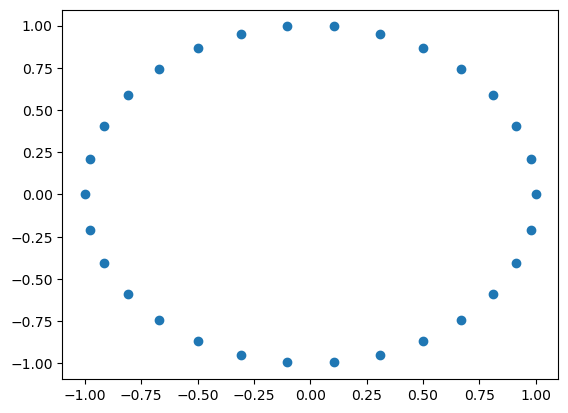

In [9]:

radius_taken = 1
centre_point= np.array([[0,0]])
angles_array = np.zeros((number_points,))

for i in range(0,angles_array.shape[0]):
    # Angle in radians
    angles_array[i] =i*2*np.pi/number_points
    
    
x=np.zeros((angles_array.shape[0],1))
y=np.zeros((angles_array.shape[0],1))

for i in range(angles_array.shape[0]):
    x[i,:] = centre_point[0,0]+radius_taken*np.cos(angles_array[i])
    y[i,:] = centre_point[0,1]+radius_taken*np.sin(angles_array[i])

circle_points = np.concatenate((x,y),axis=1)
# print(circle_points)
plt.figure()
plt.scatter(circle_points[:,0],circle_points[:,1])
plt.show()



Data Generation

In [10]:
ini_thetas=np.random.randn(reps,num_link) 

ini_configs = np.zeros((reps,num_link+1,2))
for i in range(0,reps):
    ini_configs[i,:,:]=positions(ini_thetas[i,:])

values_inv = np.zeros((reps*number_points,num_link+2))
generated_thetas=np.zeros((reps*number_points,1,num_link))
generated_config=np.zeros((reps*number_points,num_link+1,2))

for i in range(0,number_points):
    generated_thetas[i*reps:(i+1)*reps,:,:],generated_config[i*reps:(i+1)*reps,:,:]=FABRIK_solver(aim=np.reshape(circle_points[i,:], (1,2)),p=ini_configs)
    for j in range(i*reps,(i+1)*reps):
        target = np.reshape(circle_points[i,:], (1,2))
        solution_set = np.concatenate((generated_thetas[j,:,:],target),axis=1)
        values_inv[j,:]=solution_set

values_inv=np.unique(values_inv,axis=0)


Loading data into csv file

In [11]:

p_x,p_y=np.zeros((values_inv.shape[0],num_link+1)),np.zeros((values_inv.shape[0],num_link+1))


for val in range(0,values_inv.shape[0]):
    p_x[val,:],p_y[val,:] = posn(values_inv[val,:num_link])

inv_data = {'theta1':values_inv[:,0],'theta2':values_inv[:,1],'theta3':values_inv[:,2],'theta4':values_inv[:,3],
         'end_x':values_inv[:,4],'end_y':values_inv[:,5],
         'x1':p_x[:,1],'x2':p_x[:,2],'x3':p_x[:,3],'x4':p_x[:,4],
         'y1':p_y[:,1],'y2':p_y[:,2],'y3':p_y[:,3],'y4':p_y[:,4]}

df_data=pd.DataFrame(inv_data)
# print(df_data)
df_data.to_csv('INN_IK_inv_data.csv',index=False)

data_ik=(pd.read_csv('INN_IK_inv_data.csv')).values
print(type(data_ik))

np.random.seed(1)
data_ik=np.random.permutation(data_ik)

data_tens=torch.from_numpy(data_ik)
data_tens=data_tens.to(torch.float32)
data_tens=data_tens.to(device)
print(data_tens.shape)

ind_split = int(TEST_TRAIN_SPLIT*num_samples)

# Splitting the data into batches
data_train = data_tens[:ind_split,:]
data_test = data_tens[ind_split:,:]

print(data_test.dtype)
# data_train_ten, data_test_ten = torch.from_numpy(data_train), torch.from_numpy(data_test)


df_test = pd.DataFrame(data_test)
df_test.to_csv("testing_dataset.csv",index=False)
df_train = pd.DataFrame(data_train)
df_train.to_csv("training_dataset.csv", index=False)

train_dataset, test_dataset = data_train.to(torch.float32), data_test.to(torch.float32)
train_dataset, test_dataset= train_dataset.to(device), test_dataset.to(device)

# Dividing the data into minibatches
data_loader=torch.utils.data.DataLoader(dataset=data_tens,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

<class 'numpy.ndarray'>
torch.Size([300000, 14])
torch.float32


Bidirectional Training

In [12]:
loc_inn.train()
forward_loss=[]
reverse_loss=[]
z_loss_store=[]
for epoch in range(num_epochs):
    for batch_idx, data_x in enumerate(data_loader):
        optimizer.zero_grad()
        with autocast(enabled=mix_precision):
            x_train=data_x[:,:num_link]
    #         print(x_train.shape)
            y_pred,para=loc_inn.forward(x_train)
    #         print(type(y_pred))
            y_gt=data_x[:,num_link:num_link+2]
            z_sample=torch.randn((x_train.shape[0],2)).to(torch.float32)
            z_sample=z_sample.to(device)
            
            # Forward losses 
            inn_recon_loss=MSE_loss(y_pred[:,:2],y_gt)
            z_loss=MMD_matrix_multiscale(y_pred[:,2:4],z_sample,mmd_forw_kernels,device)
            
            tot_forward_loss=inn_recon_loss+z_loss
        scaler.scale(tot_forward_loss).backward(retain_graph=True)
        
        with autocast(enabled=mix_precision):
            y_train=data_x[:,4:6]
            
            samples=torch.randn((y_train.shape[0],2)).to(device)
            y_rev=torch.cat((y_train,samples),1)
            y_rev2=torch.cat((y_train,y_pred[:,2:4]),1)
            x_pred,_=loc_inn.reverse(y_rev)
            x_pred2,_=loc_inn.reverse(y_rev2)
            loss_rev_origin_z=MMD_matrix_multiscale(x_pred,x_train,mmd_back_kernels,device)
            tot_backward_loss=MSE_loss(x_pred2,x_train)+loss_rev_origin_z
        scaler.scale(tot_backward_loss).backward()
        scaler.unscale_(optimizer)
        
        scaler.step(optimizer)
        
        scaler.update()
    z_loss_store.append(z_loss.item())
    forward_loss.append(tot_forward_loss.item())
    reverse_loss.append(tot_backward_loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], FLoss:{tot_forward_loss.item()}, RLoss:{tot_backward_loss.item()}, BLoss orig:{loss_rev_origin_z.item()}")

print(y_pred[4,:], "Predicted")
print(y_rev[4,:], "True end eff, sampling done")
print(y_pred.shape)
print(y_rev.shape)

Epoch [1/30], FLoss:0.8296926617622375, RLoss:0.8509292006492615, BLoss orig:0.05652556195855141
Epoch [2/30], FLoss:0.5324314832687378, RLoss:0.4754585921764374, BLoss orig:0.048503704369068146
Epoch [3/30], FLoss:0.31286072731018066, RLoss:0.21917840838432312, BLoss orig:0.05058160796761513
Epoch [4/30], FLoss:0.2758331298828125, RLoss:0.19626063108444214, BLoss orig:0.04686649143695831
Epoch [5/30], FLoss:0.2469019889831543, RLoss:0.17309090495109558, BLoss orig:0.045619189739227295
Epoch [6/30], FLoss:0.2126588225364685, RLoss:0.1539173424243927, BLoss orig:0.04285929352045059
Epoch [7/30], FLoss:0.203827902674675, RLoss:0.1578831970691681, BLoss orig:0.0467245951294899
Epoch [8/30], FLoss:0.18899981677532196, RLoss:0.14270064234733582, BLoss orig:0.04282151162624359
Epoch [9/30], FLoss:0.1759244203567505, RLoss:0.12705819308757782, BLoss orig:0.04295184835791588
Epoch [10/30], FLoss:0.187775120139122, RLoss:0.13824695348739624, BLoss orig:0.04497646167874336
Epoch [11/30], FLoss:0

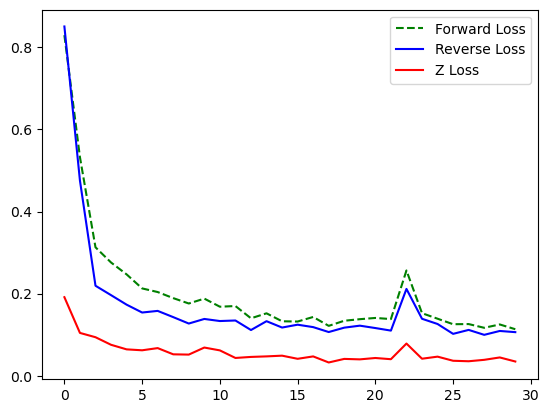

In [13]:
plt.figure()
plt.plot(forward_loss,'--g',label='Forward Loss')
plt.plot(reverse_loss,"-b",label="Reverse Loss")
plt.plot(z_loss_store,'-r',label="Z Loss")
plt.legend()
plt.show()

Saving the model parameters

In [14]:
torch.save(loc_inn.state_dict(), "INN_model.pth")

Testing

In [15]:
loc_inn.load_state_dict(torch.load("INN_model.pth"))

loc_inn.eval()
ran_int = 23567

angle_values=np.zeros((reps,4))
with torch.no_grad():
    with autocast(enabled=mix_precision):
        x_test=data_train[ran_int,0:4]
        x_test=x_test.unsqueeze(0)
        x_test.to(device)
        y_pred,param_model=loc_inn.forward(x_test)
        y_truth=data_train[ran_int,num_link:num_link+2]
        y_truth=y_truth.unsqueeze(0)
        
        # LOSS
        inn_recon_loss=MSE_loss(y_pred[:,:2],y_truth)
        print(y_pred[:,:2], "Predicted value of end effector")
        print(y_truth, "Actual value of end effector")
        
        # Reverse prediction 
        count=0
        while count<reps:
            samples=torch.randn((y_pred.shape[0],2)).to(device)
            y_for_back=torch.cat((y_truth,samples),dim=1)
            x_pred,back_params=loc_inn.reverse(y_for_back)
            rev_error=MSE_loss(x_pred,x_test) 
            angles=x_pred.detach().numpy()
            
            angle_values[count,:]=angles[:,:]
            count+=1
        # print(y_pred, "Predicted")
        # print(y_for_back, "True")


tensor([[-0.7843, -0.0186]]) Predicted value of end effector
tensor([[-0.9781, -0.2079]]) Actual value of end effector


[-0.9781476  -0.20791169]
54


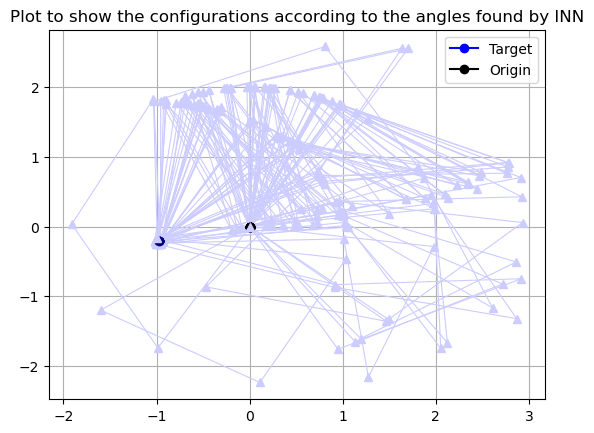

In [16]:

epsilon = 5e-2

#Plotting
p_x,p_y=np.zeros((5,count)),np.zeros((5,count))
flag=True

number_config=0

plt.figure()
for i in range(0,reps):
    p_x[:,i],p_y[:,i]=posn(phi=angle_values[i,:])
    pose_found=np.array([[p_x[-1,i],p_y[-1,i]]])
    data_comp=data_ik[ran_int,4:6].reshape((1,2))
    if np.linalg.norm(pose_found-data_ik[ran_int,4:6])<=epsilon:
        if flag==True:
            plt.plot(data_ik[ran_int,4],data_ik[ran_int,5],'b',marker='o',label="Target")
            plt.plot(0,0,'k',marker='o',label="Origin")
            plt.plot(p_x[:,i],p_y[:,i],marker='^',color=lighten_color("b",0.2),lw=0.8)
            flag=False
        
        plt.plot(data_ik[ran_int,4],data_ik[ran_int,5],color=lighten_color("b",1.5),lw=0.5,marker='o')
        plt.plot(0,0,'k',marker='o')
        plt.plot(p_x[:,i],p_y[:,i],marker='^',color=lighten_color("b",0.2),lw=0.8)

        number_config+=1
print(data_ik[ran_int,4:6])
print(number_config)   
plt.legend()
plt.grid()
plt.title("Plot to show the configurations according to the angles found by INN")
plt.show()


Training the model for trajectory tracking

In [17]:
loc_inn.eval()

# Storing the angle values
angle_values=np.zeros((reps,num_link))

# Training the model to predict the solution
with torch.no_grad():
    with autocast(enabled=mix_precision):

        y_truth = circle_points[0,:]
        y_truth=torch.from_numpy(y_truth)
        y_truth=y_truth.to(torch.float32)
        y_truth=y_truth.to(device)
        y_truth=y_truth.unsqueeze(0)
        
        # Reverse prediction 
        count=0
        while count<reps:
            samples=torch.randn((1,2)).to(device)
            y_for_back=torch.cat((y_truth,samples),dim=1)
            x_pred,back_params=loc_inn.reverse(y_for_back)
            angles=x_pred.detach().numpy()
            angle_values[count,:]=angles[:,:]
            count+=1


Finding the initial end effector configuration using the INN model

In [18]:

joints = np.zeros((reps, num_link+1, 2))
error_dist = np.zeros((reps,))

data_compare = circle_points[0,:].reshape((1,2))
pred_end_eff = end_effector_posn(phi=angle_values[:,:])
error = circle_points[0,:] - pred_end_eff
error_dist = np.linalg.norm(error, axis=1)

chosen_ind = np.argmin(error_dist)
req_angles = angle_values[chosen_ind, :] 
req_end_eff = positions(phi = req_angles)

print(req_angles * 180 / np.pi)
print(req_end_eff)

[  -7.61605708    2.72604931 -141.5273116   135.20550707]
[[ 0.          0.        ]
 [ 1.98235687 -0.26506834]
 [ 3.98009358 -0.16994717]
 [ 2.41428397 -1.4142302 ]
 [ 0.99500705 -0.00509819]]


Tracking the configuration most suitable based on based on previous end effector position using INN

In [19]:
angle_val_rest = np.zeros((number_points-1, reps, num_link))
for j in range(1,number_points):
    loc_inn.eval()
    with torch.no_grad():
        with autocast(enabled=mix_precision):

            y_truth = circle_points[j,:]
            y_truth=torch.from_numpy(y_truth)
            y_truth=y_truth.to(torch.float32)
            y_truth=y_truth.to(device)
            y_truth=y_truth.unsqueeze(0)

            # Reverse prediction 
            count=0
            while count<reps:

                samples = torch.randn((1,2)).to(device)
                y_for_back=torch.cat((y_truth,samples),dim=1)
                x_pred,back_params=loc_inn.reverse(y_for_back)
                angles=x_pred.detach().numpy()
                angles = angles.reshape((4,))
                angle_val_rest[j-1,count,:]=angles[:]
                
                count+=1

In [53]:
final_movement = np.zeros((number_points, num_link))
final_movement[0,:] = req_angles
track = req_angles.reshape((1,num_link))

for i in range(number_points-1):
    print(i+1, ")")
    data_compare = circle_points[i,:].reshape((1,2))
    pred_end_eff = end_effector_posn(phi=angle_val_rest[i,:,:])
    
    error = circle_points[i+1,:] - pred_end_eff
    error_dist = np.linalg.norm(error, axis=1)
    indices = np.where(error_dist<=epsilon)
    indices = np.array(indices)
    print(indices.shape[1], "Number of points within epsilon error")
    # error_dist = np.linalg.norm(error, axis=1).reshape(reps,1)
    change_angles = np.zeros((indices.shape[1],))
    # angles_effector = np.concatenate((angle_val_rest[i,:,:], error_dist), axis=1)
    for ind in range(indices.shape[1]):
        indi = indices[:,ind]
        change_angles[ind] = np.linalg.norm(track - angle_val_rest[i,indi,:], axis=1)
    
    change_ind = np.concatenate((change_angles.reshape((indices.shape[1],1)), indices.T), axis=1)
    chosen_ind = np.argmin(change_angles)
    req_ind = int(change_ind[chosen_ind, -1])
    # print(req_ind)
    final_movement[i+1,:] = angle_val_rest[i,req_ind,:num_link]
    track = angle_val_rest[i,req_ind,:num_link].reshape((1,num_link))
    print("for circle point", circle_points[i+1])
    print()

1 )
73 Number of points within epsilon error
for circle point [0.9781476  0.20791169]

2 )
89 Number of points within epsilon error
for circle point [0.91354546 0.40673664]

3 )
54 Number of points within epsilon error
for circle point [0.80901699 0.58778525]

4 )
58 Number of points within epsilon error
for circle point [0.66913061 0.74314483]

5 )
60 Number of points within epsilon error
for circle point [0.5       0.8660254]

6 )
52 Number of points within epsilon error
for circle point [0.30901699 0.95105652]

7 )
49 Number of points within epsilon error
for circle point [0.10452846 0.9945219 ]

8 )
41 Number of points within epsilon error
for circle point [-0.10452846  0.9945219 ]

9 )
41 Number of points within epsilon error
for circle point [-0.30901699  0.95105652]

10 )
42 Number of points within epsilon error
for circle point [-0.5        0.8660254]

11 )
38 Number of points within epsilon error
for circle point [-0.66913061  0.74314483]

12 )
44 Number of points within epsil

In [54]:
final_positions = np.zeros((number_points,num_link+1,2))

for i in range(final_movement.shape[0]):
    final_positions[i,:,:] = positions(phi=final_movement[i,:])

for j in range(circle_points.shape[0]):
    print(f"{j+1})")
    print(circle_points[j,:], "Actual")
    print(final_positions[j,-1,:], "Predicted")
    print()


1)
[1. 0.] Actual
[ 0.99500705 -0.00509819] Predicted

2)
[0.9781476  0.20791169] Actual
[0.96575631 0.22858984] Predicted

3)
[0.91354546 0.40673664] Actual
[0.86842197 0.3983081 ] Predicted

4)
[0.80901699 0.58778525] Actual
[0.83225859 0.54711725] Predicted

5)
[0.66913061 0.74314483] Actual
[0.6516562 0.7466459] Predicted

6)
[0.5       0.8660254] Actual
[0.4966618  0.84762139] Predicted

7)
[0.30901699 0.95105652] Actual
[0.33008873 0.96708359] Predicted

8)
[0.10452846 0.9945219 ] Actual
[0.14802117 0.97815534] Predicted

9)
[-0.10452846  0.9945219 ] Actual
[-0.0721639   0.99246946] Predicted

10)
[-0.30901699  0.95105652] Actual
[-0.26802915  0.92593804] Predicted

11)
[-0.5        0.8660254] Actual
[-0.51195017  0.87855123] Predicted

12)
[-0.66913061  0.74314483] Actual
[-0.66548209  0.75755106] Predicted

13)
[-0.80901699  0.58778525] Actual
[-0.78930709  0.59486003] Predicted

14)
[-0.91354546  0.40673664] Actual
[-0.88387042  0.37780092] Predicted

15)
[-0.9781476   0.20791

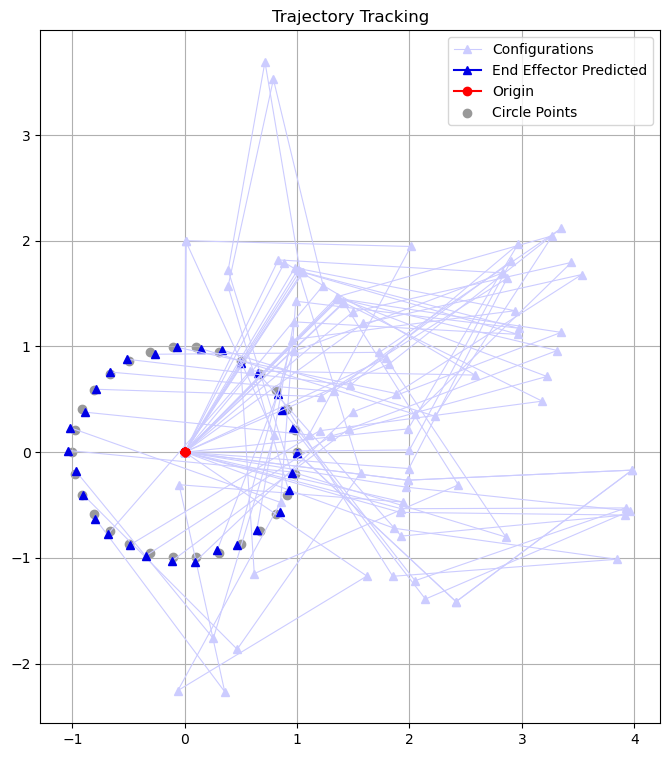

In [60]:

plt.figure(figsize=(8,9))

flag = True
for i in range(circle_points.shape[0]):
    px, py = posn(phi=final_movement[i,:])
    if flag == True:
        plt.plot(px[:], py[:], marker = "^", color = lighten_color("b", 0.2), lw=0.8, label="Configurations")
        plt.plot(px[-1], py[-1], marker="^", color = lighten_color("b", 1.1), label="End Effector Predicted")
        plt.plot(0,0, color="r", marker="o", label="Origin")
        flag = False
    plt.plot(final_positions[i,:,0], final_positions[i,:,1], marker = "^", color = lighten_color("b", 0.2), lw=0.8)
    plt.plot(px[-1], py[-1], marker="^", color = lighten_color("b", 1.1))
    plt.plot(0,0, color="r", marker="o")
    
plt.scatter(circle_points[:,0],circle_points[:,1], color=lighten_color("k", 0.4), label="Circle Points")

plt.grid()
plt.legend()
plt.title("Trajectory Tracking")
plt.show()